In [1]:
%matplotlib inline

# analyzeRadioExp automatically read experiment files and does a lot of pre-computations, etc. [version 2015, unmodified]
from analyzeRadioExp import *
import random as random_module

In [2]:
#plot3dFloorPlan()
#plotFurthestNodes() # indicate the nodes with the maximum distance

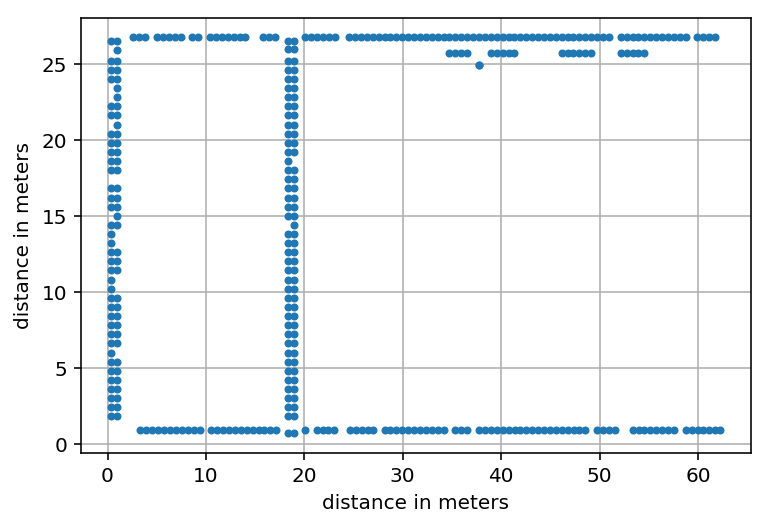

In [3]:
# plot all nodes in the network (axis unit: meters)
xlabel("distance in meters")
ylabel("distance in meters")
plot(xArray, yArray, ".")
plt.savefig("grenoble-topology-m3.pdf")
grid()


---

### Get topology information summarized in a matrix 'neighDist' 

* if nodes $u$ and $v$ are neighbors: `neighDist[u,v]` is set to 1  
* otherwise: `neighDist[u,v]` is set to the constant `InfiniteDist` 

The topology is computed for two different graphs:
* IoT-LAB grenoble topology
* a graph with nodes placed randomly in a square (for testing)

In [4]:
###### Compute the neighborhood in IoT-LAB grenoble testbed

## Copied from "analyzeRadioExp.estimateConnectivityProb" and modified:

# Channel (we have measurements on channels 11 to 26) - 26 is the cleanest, 22 has the most "noise", hence most nb hops
Channel = 20
channelIdx = Channel-11

# Link selection: nb packets received must be >= 50% nb packets send (e.g. PDR >= 50%):
NbPacketConnectivity = nbPacket /float (2)  

# Neighborhood: `neighDist[u,v]' is set to: 1 if nodes `u' and `v' are neighbors or `InfiniteDist' otherwise
InfiniteDist = 1000000
#InfiniteDist = inf
hasLink = ( (connRecv[channelIdx] >= NbPacketConnectivity) 
           & (connRecv.transpose(0,2,1)[channelIdx] >= NbPacketConnectivity) )
neighDist = (hasLink.astype(int32) 
                    + logical_not(hasLink).astype(int32) * InfiniteDist)
 
# ^^^^^^^ neighDist is the only information we need from IoT-LAB (it contains the neighborhood)


# -- the sink is selected to be one of nodes that are the furthest apart:

# compute the distance between all nodes in the networks (in hops) from the neighborhood (hopDist)
hopDist = scipy.sparse.csgraph.floyd_warshall(neighDist)
# find two nodes which are at maximum distance
furthestNodes = np.unravel_index(hopDist.argmax(), hopDist.shape)
sinkIdx = min(furthestNodes)
print ("node #%s <-> node #%s : max distance = %s hops --- selected sink is node #%s"% (furthestNodes+(hopDist.max(),sinkIdx)))

node #59 <-> node #326 : max distance = 9.0 hops --- selected sink is node #59


In [5]:
####### alternate graph: random node placement in a square
SquareWidth = 50
SquareRadioRange = 8
SquareNbNode = nbNode

# - generate nodes placed randomly in a square
asGrid = True
if not asGrid:
    np.random.seed(1)
    squareXArray = np.random.uniform(0, SquareWidth, SquareNbNode)
    squareYArray = np.random.uniform(0, SquareWidth, SquareNbNode)
else:
    q = int(sqrt(SquareNbNode)+1)
    squareXArray = (np.arange(0, nbNode) %q) /float (q) * SquareWidth
    squareYArray = (np.arange(0, nbNode) // q) /float (q) * SquareWidth

squareSinkIdx = 0 # sink in the middle:
squareXArray[squareSinkIdx], squareYArray[squareSinkIdx] = (SquareWidth /float (2), SquareWidth /float (2)) 

# - compute distance between pairs of nodes (in meters), and then the neighborhood matrix `squareInitialDist'
ncoord = np.array([squareXArray, squareYArray]).transpose()
# from: http://stackoverflow.com/questions/28687321/computing-euclidean-distance-for-numpy-in-python
D = np.sqrt(((ncoord[:, :, None] - ncoord[:, :, None].T) ** 2).sum(1))


hasSquareLink = (D < SquareRadioRange)
squareNeighDist = hasSquareLink.astype(int32) + logical_not(hasSquareLink).astype(int32) * InfiniteDist

#s = where(D[squareSinkIdx] < 7) ; plot(squareXArray[s], squareYArray[s], "*")

### Select one of the graphs  (iotlab or random-in-a-square) as 'test' graph for testing functions

In [6]:
testGraph = "square" 
testGraph = "iotlab"
#testGraph = None

if testGraph == "iotlab":
    testNeighDist = neighDist
    testSinkIdx = sinkIdx
    testXArray,testYArray = xArray, yArray
    testXYArray = np.array([xArray, yArray])
elif testGraph == "square":
    testNeighDist = squareNeighDist
    testSinkIdx = squareSinkIdx
    testXArray,testYArray = squareXArray, squareYArray
    testXYArray = np.array([testXArray, testYArray])    

if testGraph != None:    
    #plot (testXArray, testYArray, ".")
    xlabel("distance in meters")
    ylabel("distance in meters")
    plot(testXYArray[0], testXYArray[1], ".")
    plot(testXYArray[0][testSinkIdx], testXYArray[1][testSinkIdx], "or", markersize=10)
    plt.savefig("grenoble-sink-node.pdf")
    grid()

---

## Utility functions for subgraph extraction, with two different techniques:

1) extract the subset of nodes which are less than `n` hops from a reference nodes, in one given graph

2) extract a random subset of `n` nodes, in one given graph 

In [7]:
# -- Function to extract a graph of nodes which are at most at `x' hops from one reference point

# Ignore all nodes which are more than `maxNbHop' away from node #refNodeIdx
# and return the resulting "neighborhood distance", and updated `refNodeIdx' (i.e. after removing the above and renumbering)
def getCloseSubgraph(neighDist, refNodeIdx, maxNbHop):
    hopDist = scipy.sparse.csgraph.floyd_warshall(neighDist)
    closeToRefArray = where(hopDist[refNodeIdx] <= maxNbHop)[0]
    subgraphNeighDist = neighDist[closeToRefArray][...,closeToRefArray].copy()
    currentRefNodeIdx = where(closeToRefArray == refNodeIdx)[0][0] # idx changed because of taking subset -> renumbering
    return closeToRefArray, subgraphNeighDist, currentRefNodeIdx

# Testing the function:
if testGraph != None:
    print ("test: subset of nodes limited distance (#hops) from the sink")
    closeNodeIdxArray, closeNeighDist, closeSinkIdx = getCloseSubgraph(testNeighDist, testSinkIdx, maxNbHop=5)
    xlabel("distance in meters")
    ylabel("distance in meters")
    plot(testXArray[closeNodeIdxArray], testYArray[closeNodeIdxArray], "*")
    print closeNeighDist.shape

test: subset of nodes limited distance (#hops) from the sink
(215, 215)


In [8]:
# -- Function to extract `x' random nodes from a graph

def getRandomSubgraph(neighDist, sinkIdx, nbSubsetNode, seed):
    myNbNode = neighDist.shape[0]
    
    # select `nbSubsetNode-1' random nodes plus node `sinkIdx'
    random_module.seed(seed)
    nodeList = range(myNbNode)
    nodeList.remove(sinkIdx)
    random_module.shuffle(nodeList)
    nodeSubsetArray = np.array([sinkIdx] + nodeList[0:nbSubsetNode-1])

    subgraphNeighDist = neighDist[nodeSubsetArray][...,nodeSubsetArray].copy()
    currentSinkIdx = where(nodeSubsetArray == sinkIdx)[0][0] # idx changed because of taking subset -> renumbering

    return nodeSubsetArray, subgraphNeighDist, currentSinkIdx 


# Testing the function:
if testGraph != None:
    print ("test: (this is a subset of the previous plot)")
    subgraphNodeIdxArray, subgraphNeighDist, subgraphSinkIdx = getRandomSubgraph(closeNeighDist, closeSinkIdx, nbSubsetNode=40, seed=8)
    subgraphNodeIdxArray = closeNodeIdxArray[subgraphNodeIdxArray] # because double re-numbering
    xlabel("distance in meters")
    ylabel("distance in meters")
    plot(testXArray[subgraphNodeIdxArray], testYArray[subgraphNodeIdxArray], "o")
    plt.savefig("grenoble-reachable-m3.pdf")

test: (this is a subset of the previous plot)


In [9]:
# Construct a shortest path tree (in number of hops) from the sink to all the nodes 
# input: neighborhood 
# output: 
#    fromToArray= array of edges (to,from)  where the tree is a routing tree *to* the sink
#    coveringTree=neighborhood with only the links that are used in the routing tree
#    distanceArray= distance of node #i to the sink

def makeRoutingTree(subgraphNeighDist, subgraphSinkIdx):
    adjacency = np.zeros_like(subgraphNeighDist)
    adjacency[where(subgraphNeighDist < InfiniteDist)] = 1
    
    distanceArray = scipy.sparse.csgraph.dijkstra(adjacency, indices=subgraphSinkIdx)
    distanceArray[where(distanceArray == inf)] = -1
    if distanceArray.max() == 0: # empty tree (cannot reach any other node)
        return None, None, None

    coveringTree = scipy.sparse.csgraph.breadth_first_tree(adjacency, subgraphSinkIdx, directed=True)
    toFromArray = np.array(where(coveringTree.todense() > 0))
      
    return toFromArray.transpose(), coveringTree.todense(), distanceArray #[subgraphSinkIdx]


def computeUnicastMulticastCost(routingTree, treeToFromArray, distanceArray, probSelected=1.0):
    mcastCost = (routingTree.sum())
    assert (treeToFromArray.shape[0]) == mcastCost
    assert ((distanceArray>0).sum()) == mcastCost
    
    ucastCost = distanceArray[where(distanceArray>0)].sum()

    #return ucastCost, mcastCost    
    
    nodeInTreeList =  list(sorted(list(treeToFromArray[::,1])))
    selectedNodeSet = set([nodeId for nodeId in nodeInTreeList if  random_module.random() <= probSelected  ]) 
    
    parentTable = { child: parent for (parent, child) in treeToFromArray }
    
    treeForSelectedSet = set()
    currentSet = selectedNodeSet
    while len(currentSet) > 0:
        treeForSelectedSet = treeForSelectedSet.union(currentSet)
        currentSet = set([parentTable[nodeId] 
                          for nodeId in currentSet 
                          if nodeId in parentTable])
    selectedNodeArray = np.array(list(selectedNodeSet))
    if len(selectedNodeSet) == 0:
        return None, None, None
    
    ucastCost = distanceArray[selectedNodeArray].sum()
    mcastCost = len(treeForSelectedSet)-1 # because of the sink
    
    return ucastCost, mcastCost, len(selectedNodeSet)


# -- test the functions
if testGraph != None:
    toFromArray, routingTree, distanceArray = makeRoutingTree(subgraphNeighDist, subgraphSinkIdx)
    nbNodeInTree = (distanceArray > 0).sum()
    ucastCost, mcastCost, nbSelected = computeUnicastMulticastCost(routingTree, toFromArray, distanceArray, probSelected=1)
    print "unicast cost=%s (sum of distance) ; multicast cost=%s (number of nodes connected to the root-1)" % (ucastCost, mcastCost)
    
    globalToFromArray = subgraphNodeIdxArray[toFromArray] # local numbering in the subgraph (0,1,2) -> to global numbering of the initial graph 
    #plot(*testXYArray[::,subgraphNodeIdxArray], marker="*", linestyle="None")
    xlabel("distance in meters")
    ylabel("distance in meters")
    for i in range(toFromArray.shape[0]):
        relFromIdx = toFromArray[i,1]
        if distanceArray[relFromIdx]%2 == 1: color = "b"
        else: color = "g"
        plot(*testXYArray[::,globalToFromArray[i]], marker=".", color=color, linewidth=1)#, linewidth=distanceArray[i])
    for i in range(subgraphNeighDist.shape[0]):
        if  distanceArray[i] == 1: markerSize = 10 ; color = "b"
        elif distanceArray[i] == 0: markerSize = 15 ;  color = "r"
        elif distanceArray[i] == 2: markerSize = 7 ; color ="g"
        elif distanceArray[i] < 0: markerSize = 3 ; color = "r"
        else: markerSize = 5 ; color = "#000000"
        plot(*testXYArray[::,subgraphNodeIdxArray[i]], marker="o", color=color, markersize=markerSize)
        
    plt.savefig("grenoble-RPL.pdf")
        
        
#distanceArray.shape
#toFromArray
#distanceArray[subgraphSinkIdx]


unicast cost=198.0 (sum of distance) ; multicast cost=39 (number of nodes connected to the root-1)


---

# Final Result: Compute the avg. necessary number of transmissions (unicast or with-cache)

- A subset of the topology is taken varying the max number of hops (from the sink)
  - Then in this sub-topology, the target "number of nodes" is selected: the number goes from 10 to the max number
   - For each such number of nodes: `NbIter` experiments are run where that amount of nodes are selected randomly in the sub-topology
     - For each experiment, the cost of unicast and the cost with caching are computed (= the number of necessary transmissions) with all nodes trying to get same identical content. Disconnected nodes are not considered.

---


In [10]:
NbIter = 100

ProbSelection = 0.5

maxNbHopList = [5, 10]

ucastTable = {}
mcastTable = {}
nbNodeTable = {}
distanceTable = {}
connectedNbNodeTable = {}

for maxNbHop in maxNbHopList:
    closeNodeIdxArray, closeNeighDist, closeSinkIdx = getCloseSubgraph(neighDist, sinkIdx, maxNbHop=maxNbHop)
    nbNodeList = [2,4,6,8] + range(10, closeNodeIdxArray.shape[0], 10)

    ucastList = []
    mcastList = []
    distanceList = []
    trueNbNodeList = []
    for subsetNbNode in nbNodeList:
        itUcastCostList = []
        itMcastCostList = []
        itDistanceList = [] 
        itTrueNbNodeList = []
        for it in range(NbIter):
            subgraphNodeIdxArray, subgraphNeighDist, subgraphSinkIdx = getRandomSubgraph(
                closeNeighDist, closeSinkIdx, nbSubsetNode=subsetNbNode, seed=hash((it, subsetNbNode)))
            subgraphNodeIdxArray = closeNodeIdxArray[subgraphNodeIdxArray] # because double re-numbering
            toFromArray, routingTree, distanceArray = makeRoutingTree(subgraphNeighDist, subgraphSinkIdx)
            if toFromArray is None: 
                continue
            #print computeUnicastMulticastCost(routingTree, toFromArray, distanceArray, probSelected = ProbSelection)
            
            ucastCost, mcastCost, nbSelected = computeUnicastMulticastCost(routingTree, toFromArray, distanceArray, probSelected = ProbSelection)
            if ucastCost == None:
                continue
            #itTrueNbNodeList.append( (distanceArray>0).sum() )
            itTrueNbNodeList.append( nbSelected )
            itUcastCostList.append(ucastCost)
            itMcastCostList.append(mcastCost)
            itDistanceList.append(  distanceArray[where(distanceArray>=0)].mean() )
        ucastList.append(np.array(itUcastCostList).mean())
        mcastList.append(np.array(itMcastCostList).mean())
        distanceList.append(np.array(itDistanceList).mean())
        trueNbNodeList.append(np.array(itTrueNbNodeList).mean())
        

    ucastTable[maxNbHop] = np.array(ucastList)
    mcastTable[maxNbHop] = np.array(mcastList)
    nbNodeTable[maxNbHop] = np.array(nbNodeList)
    connectedNbNodeTable[maxNbHop] = np.array(trueNbNodeList)
    distanceTable[maxNbHop] = np.array(distanceList)


In [11]:

for maxNbHop in maxNbHopList:
    plot(nbNodeTable[maxNbHop], ucastTable[maxNbHop], ".-", label="unicast (max %s hops)" % maxNbHop)
    plot(nbNodeTable[maxNbHop], mcastTable[maxNbHop], ".-", label="calpulli (max %s hops)" % maxNbHop)

    xlabel("number of nodes")
    ylabel("total cost (#nb transmissions)")

    plt.legend(loc=0)
    grid()
    plt.savefig("nb-of-retransmitions-%s.pdf" % maxNbHop)
    show()

In [12]:
ucastTable[5]

array([   1.        ,    1.16666667,    1.72413793,    2.36111111,
          3.30769231,   11.66666667,   29.11578947,   69.24242424,
         98.2       ,  119.75      ,  140.37      ,  155.73      ,
        175.86      ,  188.74      ,  206.08      ,  215.63      ,
        232.8       ,  249.97      ,  269.25      ,  281.65      ,
        292.41      ,  312.58      ,  333.73      ,  346.24      ,  364.87      ])

In [13]:
mcastTable[5]

array([   1.        ,    1.08333333,    1.44827586,    1.80555556,
          2.34615385,    5.52      ,   10.81052632,   20.82828283,
         29.33      ,   36.62      ,   42.1       ,   48.71      ,
         54.33      ,   60.04      ,   66.11      ,   71.34      ,
         76.18      ,   82.16      ,   88.13      ,   93.5       ,
         98.01      ,  103.98      ,  110.92      ,  116.09      ,  121.98      ])

In [14]:
for maxNbHop in [5,10]:
    plot(nbNodeTable[maxNbHop], ucastTable[maxNbHop]/connectedNbNodeTable[maxNbHop], ".-", label="unicast (max %s hops)" % maxNbHop)
    plot(nbNodeTable[maxNbHop], mcastTable[maxNbHop]/connectedNbNodeTable[maxNbHop], ".-", label="calpulli (max %s hops)" % maxNbHop)
    
    #plot(nbNodeTable[maxNbHop], distanceTable[maxNbHop], ".-", label="avg distance (max %s hops)" % maxNbHop)
    print (maxNbHop, "avgdistance=", distanceTable[maxNbHop][-1].mean())

    plt.legend(loc=0)
    grid()

    xlabel("number of nodes")
    ylabel("avg. cost per node (#nb transmission / nb node)")
    plt.savefig("avg-cost-per-node-%s.pdf" % maxNbHop)
    show()



(5, 'avgdistance=', 3.4673809523809518)


(10, 'avgdistance=', 4.701352941176471)
